In [24]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data  = pd.read_csv('co2.csv', parse_dates=['date'], index_col='date')
data.isnull().sum()

co2    59
dtype: int64

## Resample

<Axes: xlabel='date'>

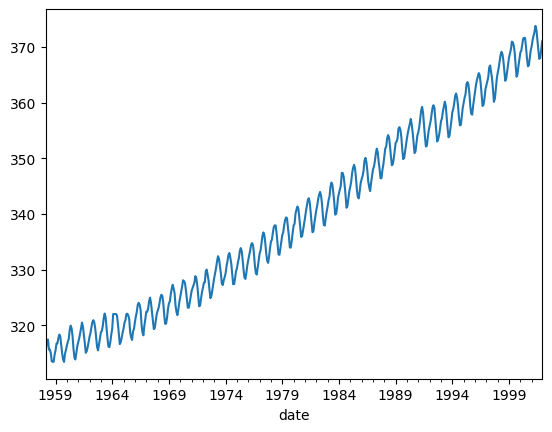

In [8]:
df = data['co2'].resample('MS').mean()
df = df.fillna(df.bfill())
df.plot()

## Detrending

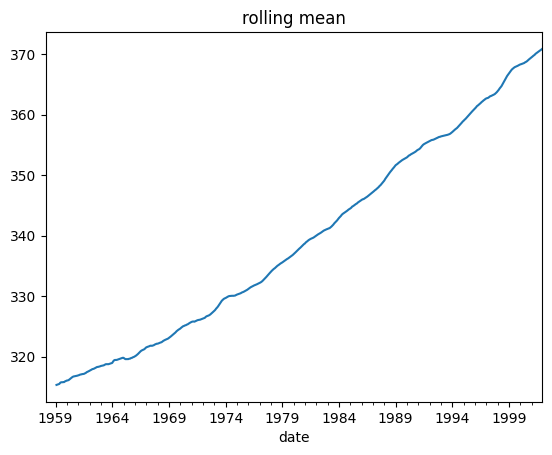

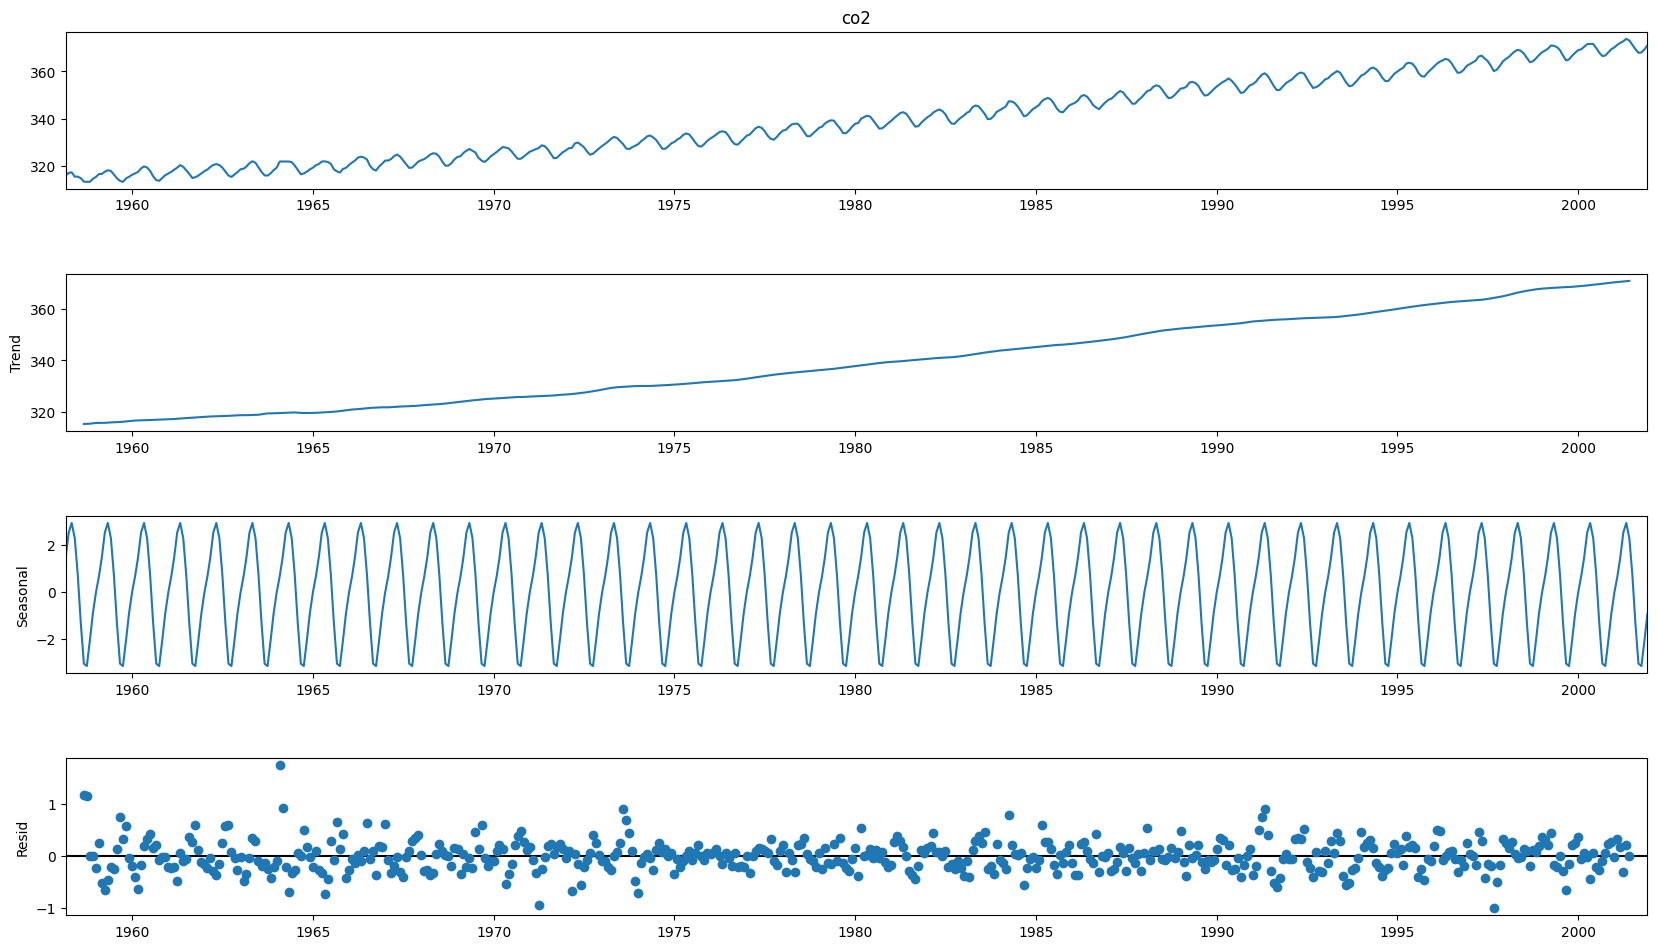

In [25]:
y = df.rolling(window=12).mean()
y.plot(title = 'rolling mean')
decomposed = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposed.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

ADF Statistic: -12.181866
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


<Axes: xlabel='date'>

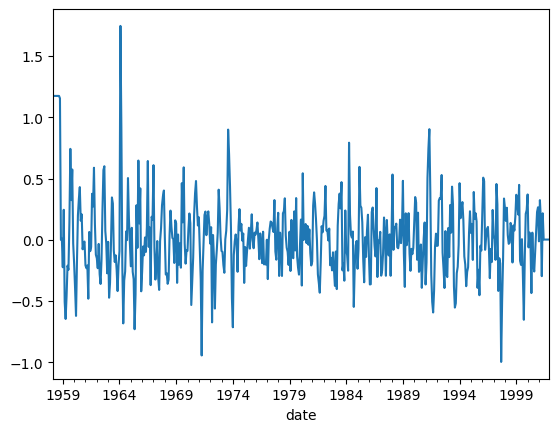

In [20]:
# Test the stationarity of residual
res = decomposed.resid.fillna(decomposed.resid.bfill())
res = res.fillna(res.ffill())
adf = adfuller(res)
print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])
print('Critical Values:')
for key, value in adf[4].items():
	print('\t%s: %.3f' % (key, value))
res.plot()

ADF Statistic for trend: 1.761347
p-value for trend: 0.998269
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


<Axes: xlabel='date'>

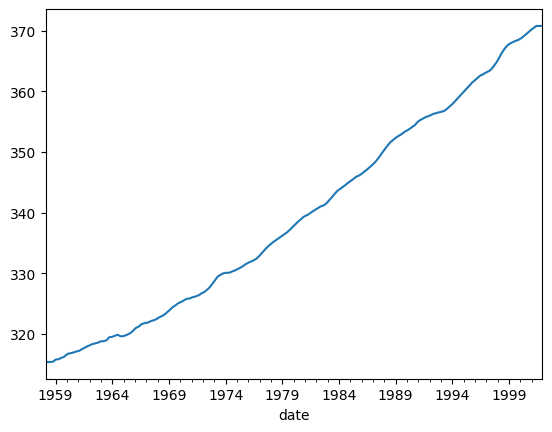

In [22]:
#Test the trend
trend = decomposed.trend.fillna(decomposed.trend.bfill())
trend = trend.fillna(trend.ffill())
adf_T = adfuller(trend)
print('ADF Statistic for trend: %f' % adf_T[0])
print('p-value for trend: %f' % adf_T[1])
print('Critical Values:')
for key, value in adf_T[4].items():
	print('\t%s: %.3f' % (key, value))
trend.plot()

## Plot ACF and PACF

Text(0.5, 1.0, 'Partial Autocorrelation Function')

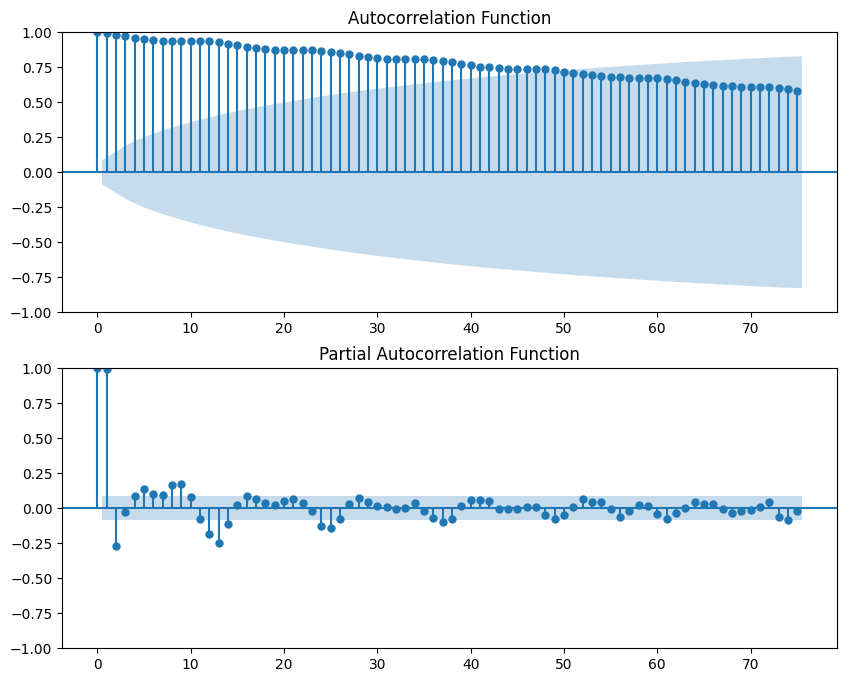

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df,ax=ax1,lags=75)
ax1.set_title('Autocorrelation Function')
plot_pacf(df, ax=ax2, lags=75)
ax2.set_title('Partial Autocorrelation Function')

## Train Model

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20140D+00    |proj g|=  7.33263D-02

At iterate    5    f=  1.19886D+00    |proj g|=  7.53011D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   1.903D-06   1.199D+00
  F =   1.1988612234696618     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


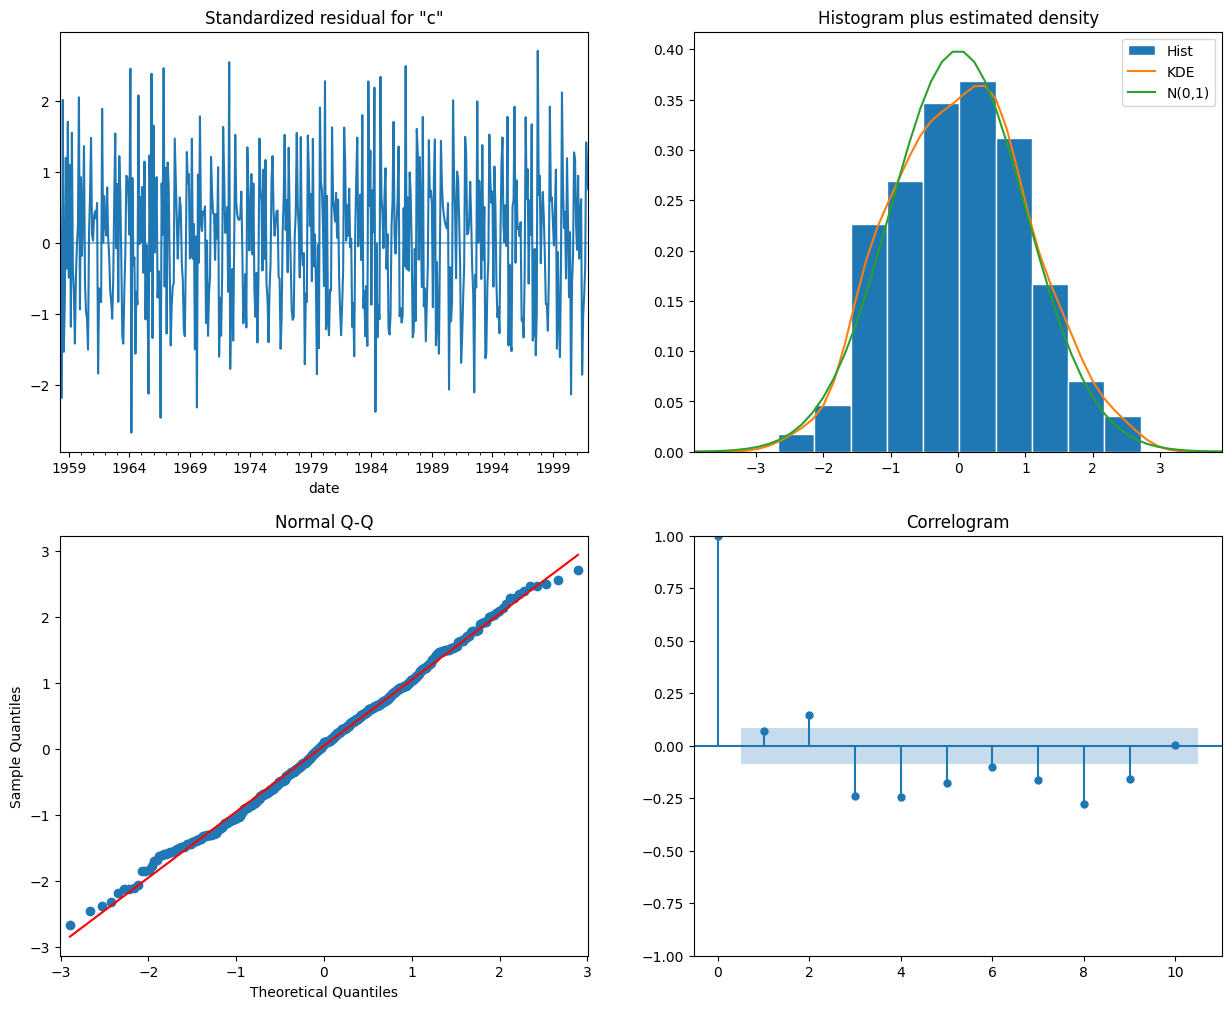

In [31]:
mod = sm.tsa.statespace.SARIMAX(df, order=(1, 1, 1))
model = mod.fit()
model.plot_diagnostics(figsize=(15, 12))
plt.show()

## Predict

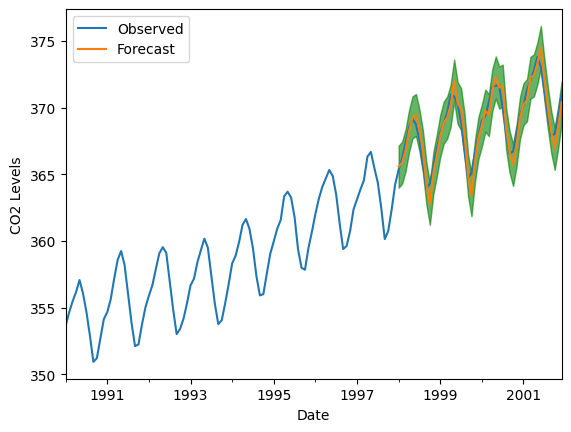

The Mean Squared Error of our forecasts is 0.57


In [36]:
pred = model.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False) # Use real number to predict
pred_ci = pred.conf_int()

ax = df['1990':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='g', alpha=.6)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

#MSE
forecasted = pred.predicted_mean
truth = df['1998-01-01':]
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

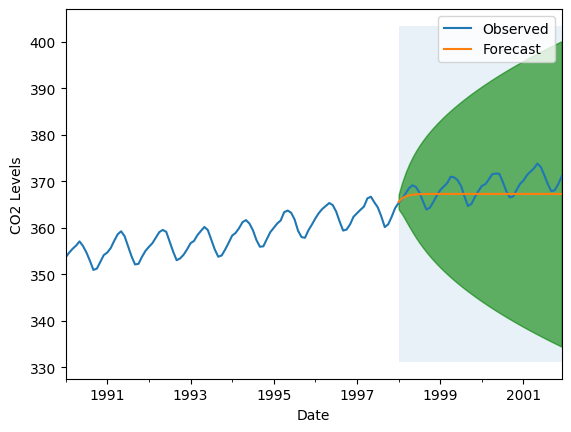

The Mean Squared Error of this forecasts is 7.81


In [38]:
pred = model.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True) # Use predicted number to predict
pred_ci = pred.conf_int()

ax = df['1990':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='g', alpha=.6)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1], alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()
#MSE
forecasted = pred.predicted_mean
truth = df['1998-01-01':]
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of this forecasts is {}'.format(round(mse, 2)))